In [267]:
import numpy as np
import math
from timeit import default_timer as timer
import scipy
import random
from random import choices
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
from scipy.sparse import dok_matrix
import scipy.stats as st
from scipy.optimize import fsolve
import heapq
import sys
import importlib
import healpy as hp
#import myUnitsCopy1 as myU # customized library for units. All dimensional variables are in GeV and GeV=1
import pandas as pd

from astropy.time import Time
from time import time as tictoc

import myUnits as myU

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import *

In [268]:
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import astropy.units as u
import matplotlib.pyplot as plt

In [269]:
from os import listdir
import gzip

# Load in a single edr3 file

In [270]:
N_8 = 2**(59-16)
N_12 = 2**(59-24)

list_dr3_files = listdir('./edr3_data')

healpix_numbers_start = np.empty((len(list_dr3_files)),dtype= int)
healpix_numbers_end = np.empty((len(list_dr3_files)), dtype = int)
for i,file in enumerate(list_dr3_files):
    int_1 = int(file[11:17])
    int_2 = int(file[18:24])
    healpix_numbers_start[i] = int_1
    healpix_numbers_end[i] = int_2
    
dr32_sid_start = [x*N_8 for x in healpix_numbers_start]
dr32_sid_end = [x*N_8 for x in healpix_numbers_end]

In [271]:
print("Pixels at level 8 (start): " + str(healpix_numbers_start))
print("Pixels at level 8 (end): " + str(healpix_numbers_end))

print("Corresponding source IDs in dr2 (start) : " + str(dr32_sid_start))
print("Corresponding source IDs in dr2 (end) : " + str(dr32_sid_end))

Pixels at level 8 (start): [     0  22882 603105]
Pixels at level 8 (end): [  3111  23058 603165]
Corresponding source IDs in dr2 (start) : [0, 201272200534163456, 5304967682158755840]
Corresponding source IDs in dr2 (end) : [27364645392089088, 202820312906072064, 5305495447740088320]


In [272]:
dr3 = pd.read_csv('./edr3_data/GaiaSource_603105-603165.csv')

## Open the corresponding dr2 files

In [273]:
dr2_data = './dr2_data' # Replace this with the path to dr2 data

list_dr2_files = listdir(dr2_data); 
list_files = [file for file in list_dr2_files if file[-7:]=='.csv.gz'] #select only files ending with 'csv.gz'

print('total number of EDR2 files =', len(list_files));
print('first five files:')
[print(file) for file in list_files[0:5]];

dr2 = pd.concat((pd.read_csv('./dr2_data/'+ str(f), compression = 'gzip') for f in list_files))

total number of EDR2 files = 14
first five files:
GaiaSource_5304947822231472384_5304989161307350400.csv.gz
GaiaSource_5304989191362501248_5305034962840493312.csv.gz
GaiaSource_5305034992891527552_5305080764372793856.csv.gz
GaiaSource_5305080794421418624_5305121205784160256.csv.gz
GaiaSource_5305121235833452288_5305156733754798848.csv.gz


# Pair Matching

First generate a list of pairs by proximity, then find the most likely dr2 match based on several criteria, described in the "get_norm" function.

In [274]:
def generate_pairs_list(dr3, dr2):
    ra_arr1 = np.asarray(dr3['ra'])
    dec_arr1 = np.asarray(dr3['dec'])

    ra_arr2 = np.asarray(dr2['ra'])
    dec_arr2 = np.asarray(dr2['dec'])
    
    coord1 = SkyCoord(ra_arr1, dec_arr1, unit = u.degree)
    coord2 = SkyCoord(ra_arr2, dec_arr2, unit = u.degree)
    
    z = search_around_sky(coord1, coord2, 3*u.arcsec, storekdtree = False)
    
    df1 = dr3.iloc[z[0]]
    df2 = dr2.iloc[z[1]]
    
    df1.reset_index(inplace = True, drop=True)
    df2.reset_index(inplace = True, drop=True)
    
    new_cols = [x+".1" for x in df2.columns]
    df2.columns= new_cols
    result = pd.concat([df1,df2], axis = 1)
    return result

In [275]:
def propagate_back_linear(ra_g3, dec_g3, pmra_g3, pmdec_g3):
    """Takes EDR3 position and proper motion, and linearly propagates it by 0.5 year to the DR2 epoch. Output: SkyCoord object in DR2 epoch. Does not take into account parallax."""
    c = SkyCoord(ra = ra_g3 * u.deg, 
                 dec = dec_g3 * u.deg, 
                 distance = 1 * u.kpc, #setting distance to 1 kpc, otherwise it thinks stuff is at 10 Mpc and then returns an exception due to faster than light
                 pm_ra_cosdec = pmra_g3 * u.mas/u.yr,
                 pm_dec = pmdec_g3 * u.mas/u.yr,
                 obstime = Time(2016.0, format='jyear'))
    return c.apply_space_motion(Time(2015.5, format='jyear'))

In [276]:
def get_norm(pairs_list):
    
    #Propagate back and add two new columns containing the calculated dr2 position
    z = propagate_back_linear(pairs_list['ra'].to_numpy(), pairs_list['dec'].to_numpy(), pairs_list['pmra'].to_numpy(), pairs_list['pmdec'].to_numpy())
    pairs_list['ra_2'] = z.ra
    pairs_list['dec_2'] = z.dec
    
    #List of conditions
    
    
    conditions = [
    (~pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    (~pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    (~pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (~pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    (pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    (pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    ]
    
    #Contingent on each condition, evaluate the following normalized norm:
    norms = [
    (1/7)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2) + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2) + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    
    (1/4)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2)   + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2) + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    (1/6)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)  + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    (1/6)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)  + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2)),
    
    (1/5)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)),
    (1/3)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2)   + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2)),
    (1/3)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2)   + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    
    (1/2)*((pairs_list['ra_2']-pairs_list['ra.1'])**2/(pairs_list['ra_error']**2) + (pairs_list['dec_2']-pairs_list['dec.1'])**2/(pairs_list['dec_error']**2)) 
    ]

    pairs_list['norm'] = np.select(conditions, norms, default=False)
    return pairs_list

In [277]:
def match_pairs(pairs_list1):
    pairs_list = get_norm(pairs_list1)
    #mask by condition norm < 4
    first_cut = pairs_list[pairs_list['norm']<4]
    first_cut.shape
    
    #Sort by source id, then norm. The duplicates with the smallest norm are at the top of their respective "chunk."
    first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
    
    #Drop all duplicates, keep the one with the smallest norm
    first_cut.drop_duplicates(subset=['source_id'],keep = 'first', inplace=True)
    
    #Do the same, except for dr2 source. This ensures that two different dr3 sources don't get matched to the same dr2 source.
    #Keep the one with the smallest norm
    first_cut.sort_values(['source_id.1', 'norm'], ascending = [True, True],inplace=True)
    first_cut.drop_duplicates(subset=['source_id.1'],keep = 'first', inplace=True)
    
    #Re-sort the dataframe by edr3 source id, for convenience
    first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
    
    return first_cut

In [278]:
t3 = 34.12/12
t2 = 21.96/12

tg3 = 10.6849/12
tg2 = 17.26/12

#functions to compute the ra of 
hacky_accel_ra = lambda ra2,ra3, pmra2, pmra3 : 12*((ra2-ra3)*3600000 - pmra2*tg2 + pmra3*tg3)/(t3**2 - t2**2)
hacky_accel_dec = lambda dec2,dec3, pmdec2, pmdec3: 12*((dec2-dec3)*3600000 - pmdec2*tg2 + pmdec3*tg3)/(t3**2 - t2**2)

#function to find the error of the hacky acceleration
hacky_error = lambda sig2,sig3 : 12*(np.sqrt(sig2**2 + sig3**2))/(t3**2 - t2**2)

#function to find the magnitude of the acceleration
accel_mag = lambda accelra, acceldec : np.sqrt(accelra**2 + acceldec**2)

In [279]:
pairs_list = generate_pairs_list(dr3,dr2)
pair_df = get_norm(pairs_list)

/home/andreas/anaconda3/envs/lens_project/lib/python3.9/site-packages/erfa/core.py:4721: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/home/andreas/anaconda3/envs/lens_project/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 55949 of "solution didn't converge (Note 8)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [280]:
def generate_accel_cat(dr3, dr2):
    
    pairs_list = generate_pairs_list(dr3,dr2)
    pair_df = match_pairs(pairs_list)
    pair_df = pair_df[~pair_df['pmra'].isna() & ~pair_df['pmra.1'].isna()]
    
    #making lists of the function inputs.
    ra2_list = np.array(pair_df['ra.1'])
    ra3_list = np.array(pair_df['ra'])

    dec2_list = np.array(pair_df['dec.1'])
    dec3_list = np.array(pair_df['dec'])

    ra2_error = np.array(pair_df['ra_error.1'])
    ra3_error = np.array(pair_df['ra_error'])

    dec2_error = np.array(pair_df['dec_error.1'])
    dec3_error = np.array(pair_df['dec_error'])
    
    pmra3 = np.asarray(pair_df['pmra'])
    pmdec3 = np.asarray(pair_df['pmdec'])

    pmra2 = np.asarray(pair_df['pmra.1'])
    pmdec2 = np.asarray(pair_df['pmdec.1'])
    
    #compute lists of accelerations
    accel_ra = hacky_accel_ra(ra2_list, ra3_list, pmra2, pmra3)
    accel_dec = hacky_accel_dec(dec2_list, dec3_list, pmdec2, pmdec3)
    accel_mag_list = accel_mag(accel_ra, accel_dec)
    
    pair_df['accel_ra'] = accel_ra
    pair_df['accel_dec'] = accel_dec
    pair_df['accel_mag'] = accel_mag_list
    
    return pair_df

In [281]:
accel_cat = generate_accel_cat(dr3, dr2)

/tmp/ipykernel_193/2254177642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
/tmp/ipykernel_193/2254177642.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.drop_duplicates(subset=['source_id'],keep = 'first', inplace=True)
/tmp/ipykernel_193/2254177642.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.sort_values(['source

# Plots

In [282]:
accel_mag_list = np.asarray(accel_cat['accel_mag'])
accel_ra_list =  np.asarray(accel_cat['accel_ra'])
accel_dec_list = np.asarray(accel_cat['accel_dec']) 
bn = np.logspace(-1,4.5,200)

Acceleration Magnitude:

Average acceleration of this sample: 59.71054906487432 
Largest acceleration of this sample: 14871.699116892905
Smallest acceleration of this sample: 0.043103822095201236 
Variance: 330986.6540340782


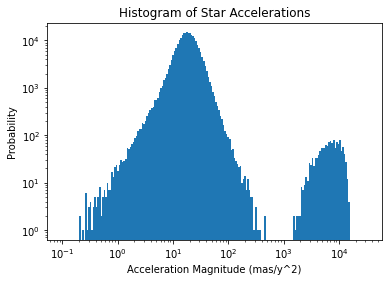

In [283]:
plt.hist(accel_mag_list, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Probability')
plt.xscale('log')
plt.xlabel('Acceleration Magnitude (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_mag_list)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accel_mag_list))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accel_mag_list))+ " ")
print("Variance: " + str(np.var(accel_mag_list)))

Acceleration in Right Ascension

Average acceleration of this sample: 16.13538535839183 
Largest acceleration of this sample: 14870.837519973327
Smallest acceleration of this sample: -14797.483478447055 
Variance: 261672.48118405524


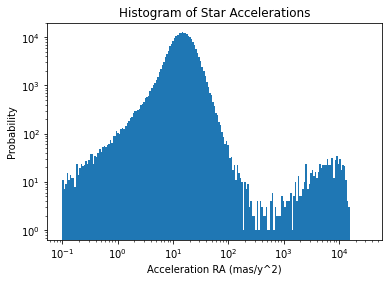

In [284]:
plt.hist(accel_ra_list, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Probability')
plt.xscale('log')
plt.xlabel('Acceleration RA (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_ra_list)) + " ")
print("Largest acceleration of this sample: " + str(max(accel_ra_list))+ "")
print("Smallest acceleration of this sample: " + str(min(accel_ra_list))+ " ")
print("Variance: " + str(np.var(accel_ra_list)))

Average acceleration of this sample: -10.427068468783737 
Largest acceleration of this sample: 7427.150625031959
Smallest acceleration of this sample: -7505.532940547233 
Variance: 72510.4481021351


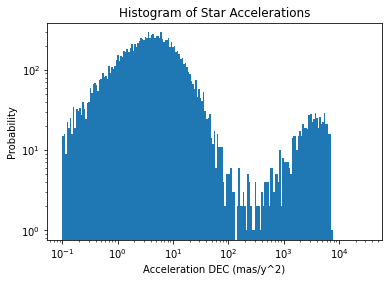

In [285]:
plt.hist(accel_dec_list, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Probability')
plt.xscale('log')
plt.xlabel('Acceleration DEC (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_dec_list)) + " ")
print("Largest acceleration of this sample: " + str(max(accel_dec_list))+ "")
print("Smallest acceleration of this sample: " + str(min(accel_dec_list))+ " ")
print("Variance: " + str(np.var(accel_dec_list)))